In [1]:
import os
import sys
import logging
import cv2
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ast import literal_eval
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pickle


%matplotlib inline
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('TestClassifier')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vehicle_detector.object_detection import ObjectDetector
from vehicle_detector.descriptors import HOG
from vehicle_detector.utils import image_utils

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [36]:
test_image_names = list(filter(lambda x: x.endswith('.jpg')==True, os.listdir('../test_images')))
print(test_image_names)
test_image_paths = list(map(lambda x: os.path.join('../test_images', x), test_image_names))
test_images = [cv2.imread(i) for i in test_image_paths]

['test2.jpg', 'test6.jpg', 'test5.jpg', 'test1.jpg', 'test4.jpg', 'test3.jpg']


In [3]:
np.mean(test_images, axis=0).shape

(720, 1280, 3)

In [4]:
def get_params_from_dataset_name(dataset_name):
    offset = 0
    if 'unfiltered' in dataset_name:
        offset = 1
    tokens = dataset_name.split('_')
    params = {
        'C': literal_eval(tokens[3+offset]),
        'gamma': tokens[5+offset] if tokens[5+offset]=='auto' else literal_eval(tokens[5+offset]),
        'color_hist': literal_eval(tokens[7+offset]),
        'orientations': literal_eval(tokens[9+offset]),
        'pixels_per_cell': literal_eval(tokens[11+offset]),
        'cells_per_block': literal_eval(tokens[13+offset]),
        'hog_color_space': os.path.splitext(tokens[15+offset])[0]
    }
    return params

In [5]:
def show_n_m_grid(data, cmap='gray', rows=4, cols=2, axis='off', image=True):
    
    f, axes = plt.subplots(rows, cols, figsize=(20,20) )
    f.tight_layout()
    for idx, datum in enumerate(data):
        row = idx // cols
        col = idx % cols
        if axis=='off':
            axes[row, col].axis('off')
        if image==True:
            axes[row, col].imshow(datum, cmap=cmap, aspect="auto")
        else:
            axes[row, col].plot(datum)

In [6]:
with open('../data/top_models.json', 'r') as fp:
    top_models = json.load(fp)


top_models.sort(key=lambda x: x['accuracy'], reverse=True)

f_top_models = list(filter(lambda x: 'unfiltered' not in x['name'], top_models))
uf_top_models = list(filter(lambda x: 'unfiltered' in x['name'], top_models))

In [7]:

model_details = uf_top_models[0]

clf = pickle.loads(open(model_details['file_path'] ,'rb').read())
scaler = pickle.loads(open(model_details['scaler_file_path'], 'rb').read())
params = get_params_from_dataset_name(model_details['name'])
model_details
params

{'C': 10,
 'cells_per_block': (4, 4),
 'color_hist': True,
 'gamma': 'auto',
 'hog_color_space': 'BGR2YCrCb',
 'orientations': 12,
 'pixels_per_cell': (16, 16)}

In [8]:
hog_descriptor = HOG(params['orientations'], params['pixels_per_cell'], params['cells_per_block'])
object_detector = ObjectDetector(clf, scaler, hog_descriptor, params['color_hist'], 
                                 params['hog_color_space'], ystart=400, ystop=650)


In [30]:
def find_cars(image, scales=[1, 1.25, 1.5, 1.75, 2.0, 2.2]):
    draw_img = np.copy(image)
    bboxes, probs = object_detector.detect(image, scales)
    draw_img = image_utils.draw_boxes(image, bboxes, color=(0, 0, 255), thick=2)
    draw_img = cv2.line(draw_img, (0, 400), (1280,400), (255,0,0), thickness=2)
    return cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

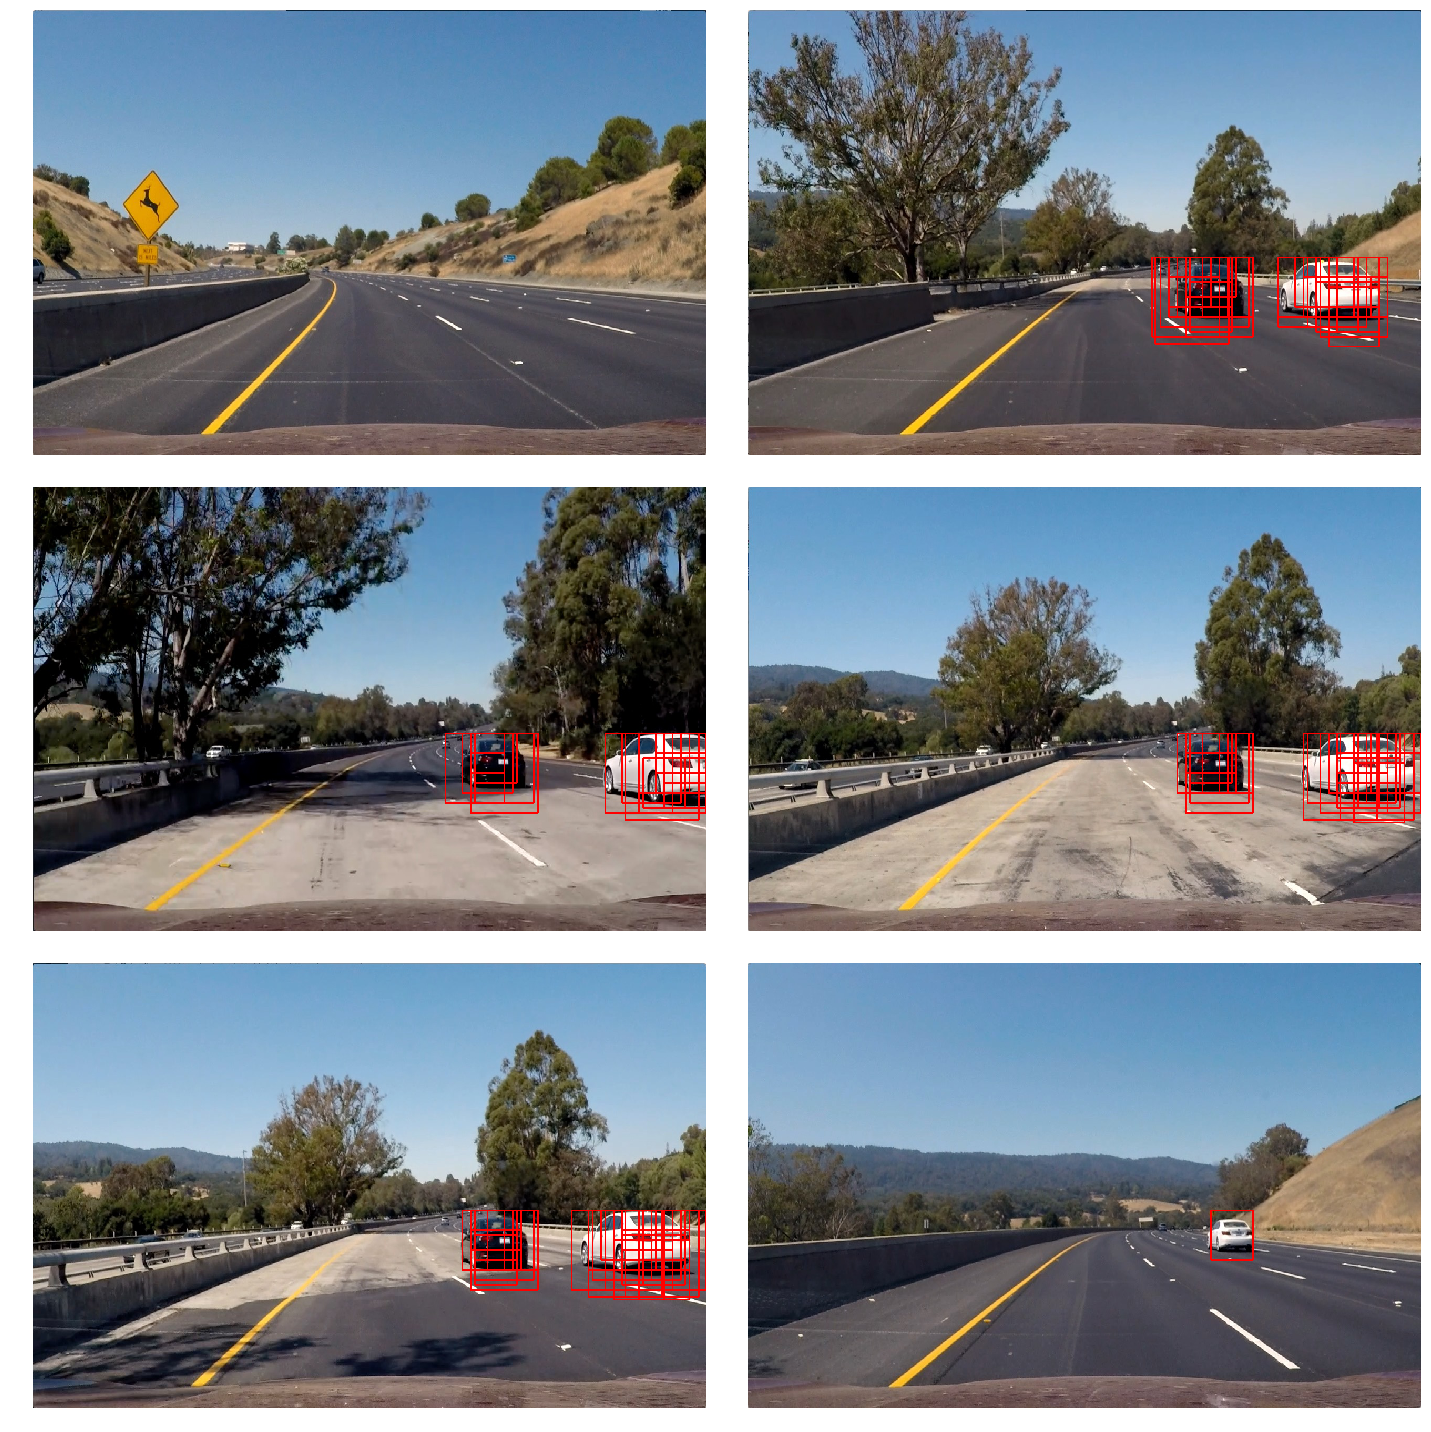

In [10]:

cars_drawn_imgs = [find_cars(i) for i in test_images]
show_n_m_grid(cars_drawn_imgs, cmap=None, rows=3, cols=2)

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[1]:box[3], box[0]:box[2]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [12]:
def draw_heat_map(image):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    bboxes, probs = object_detector.detect(image, scales=[1, 1.25, 1.5, 1.75, 2.0, 2.2])
    heatmap = add_heat(heatmap, bboxes)
    heatmap = np.clip(heatmap, 0, 255)
    return heatmap

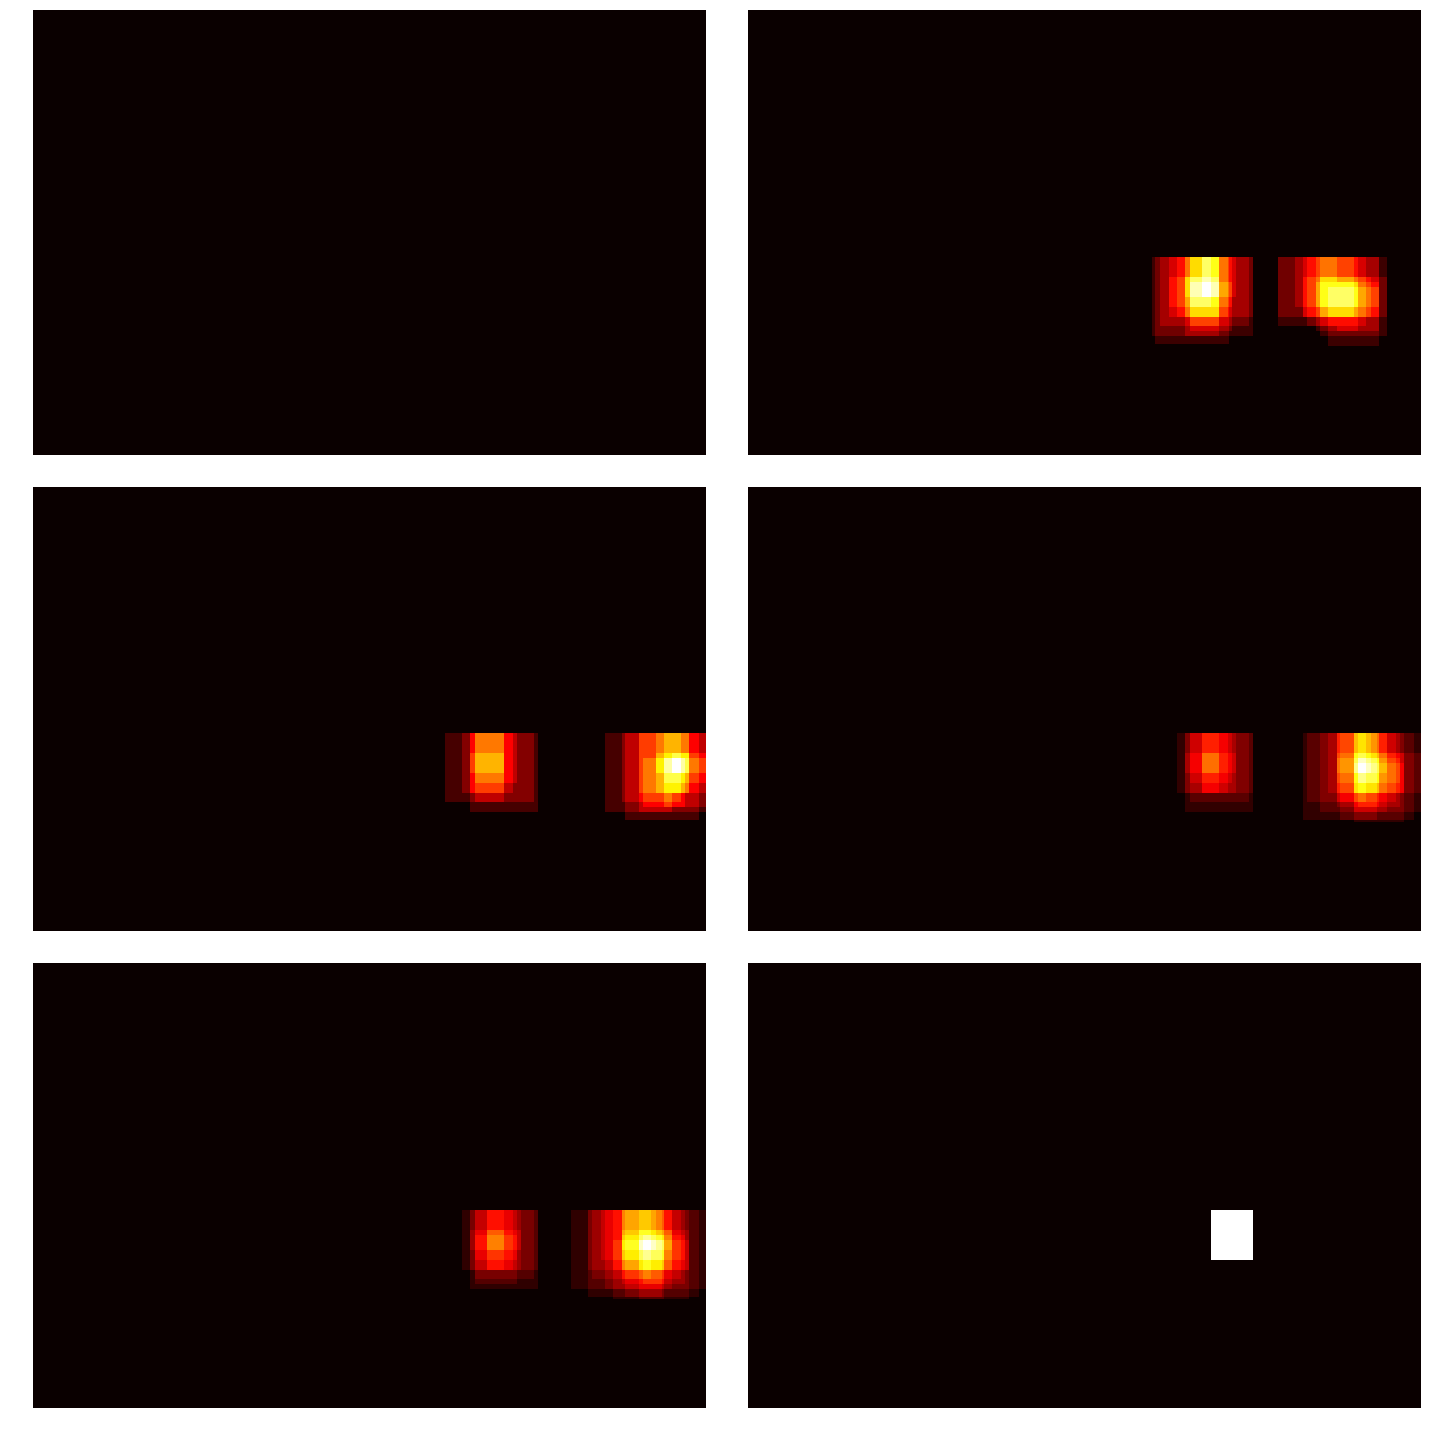

In [13]:
heatmaps = [draw_heat_map(i) for i in test_images]
show_n_m_grid(heatmaps, cmap='hot', rows=3, cols=2,)

In [14]:
heatmap = heatmaps[2]
ratio = 250/heatmap.max()
zero_img = np.zeros_like(heatmap)
heatmap_rgb = np.dstack(((heatmap*ratio).astype(np.uint8), zero_img, zero_img))

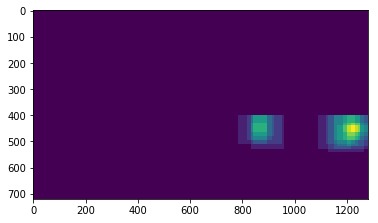

In [15]:
mn = np.min(heatmap)
mx = np.max(heatmap)
output = np.uint8((heatmap - mn) *255 / ( mx - mn))
plt.imshow(output)

In [16]:
from collections import deque


In [17]:
last_frames = deque(maxlen=5)
last_frames.append(heatmap)
last_frames.append(heatmap)
last_frames.append(heatmap)
last_frames.append(heatmap)
last_frames.append(heatmap)
last_frames.append(heatmap)


In [18]:
weights = [0.1, 0.2, 0.4, 0.6, 0.8]
avg_heat_map = np.zeros_like(heatmap)
for i,weight in enumerate(weights):
    avg_heat_map += last_frames[i] * weight


In [19]:
avg_heat_map.max()/ sum(weights)

11.0

In [22]:
np.mean(heatmaps, axis=0).shape

(720, 1280)

In [23]:
video_images_path = ['../data/691.jpg', '../data/620.jpg', '../data/637.jpg',
                     '../data/675.jpg', '../data/155.jpg', '../data/126.jpg']
video_images = [cv2.imread(i) for i in video_images_path]



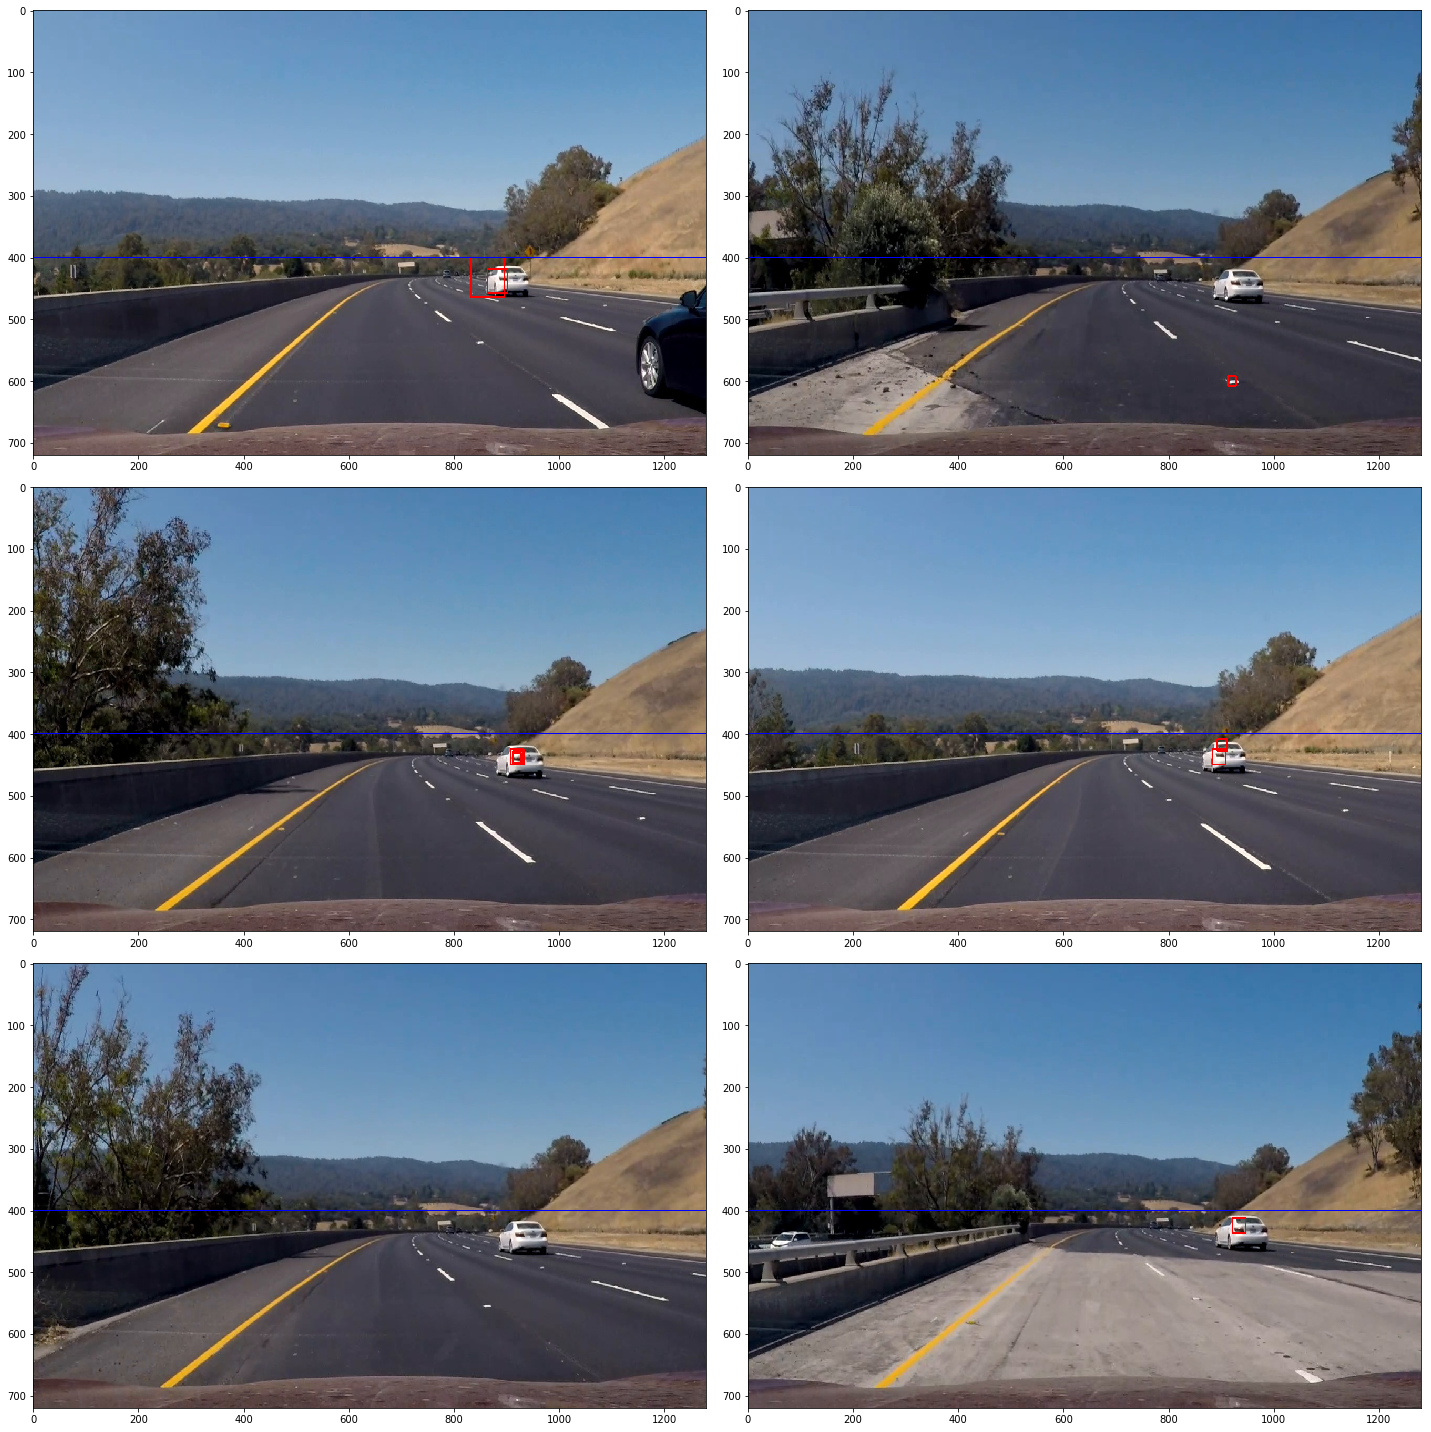

In [32]:
drawn_imgs = [find_cars(i, scales=[0.25, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9, 1.0]) for i in video_images]
show_n_m_grid(drawn_imgs, cmap=None, axis='on', rows=3, cols=2)

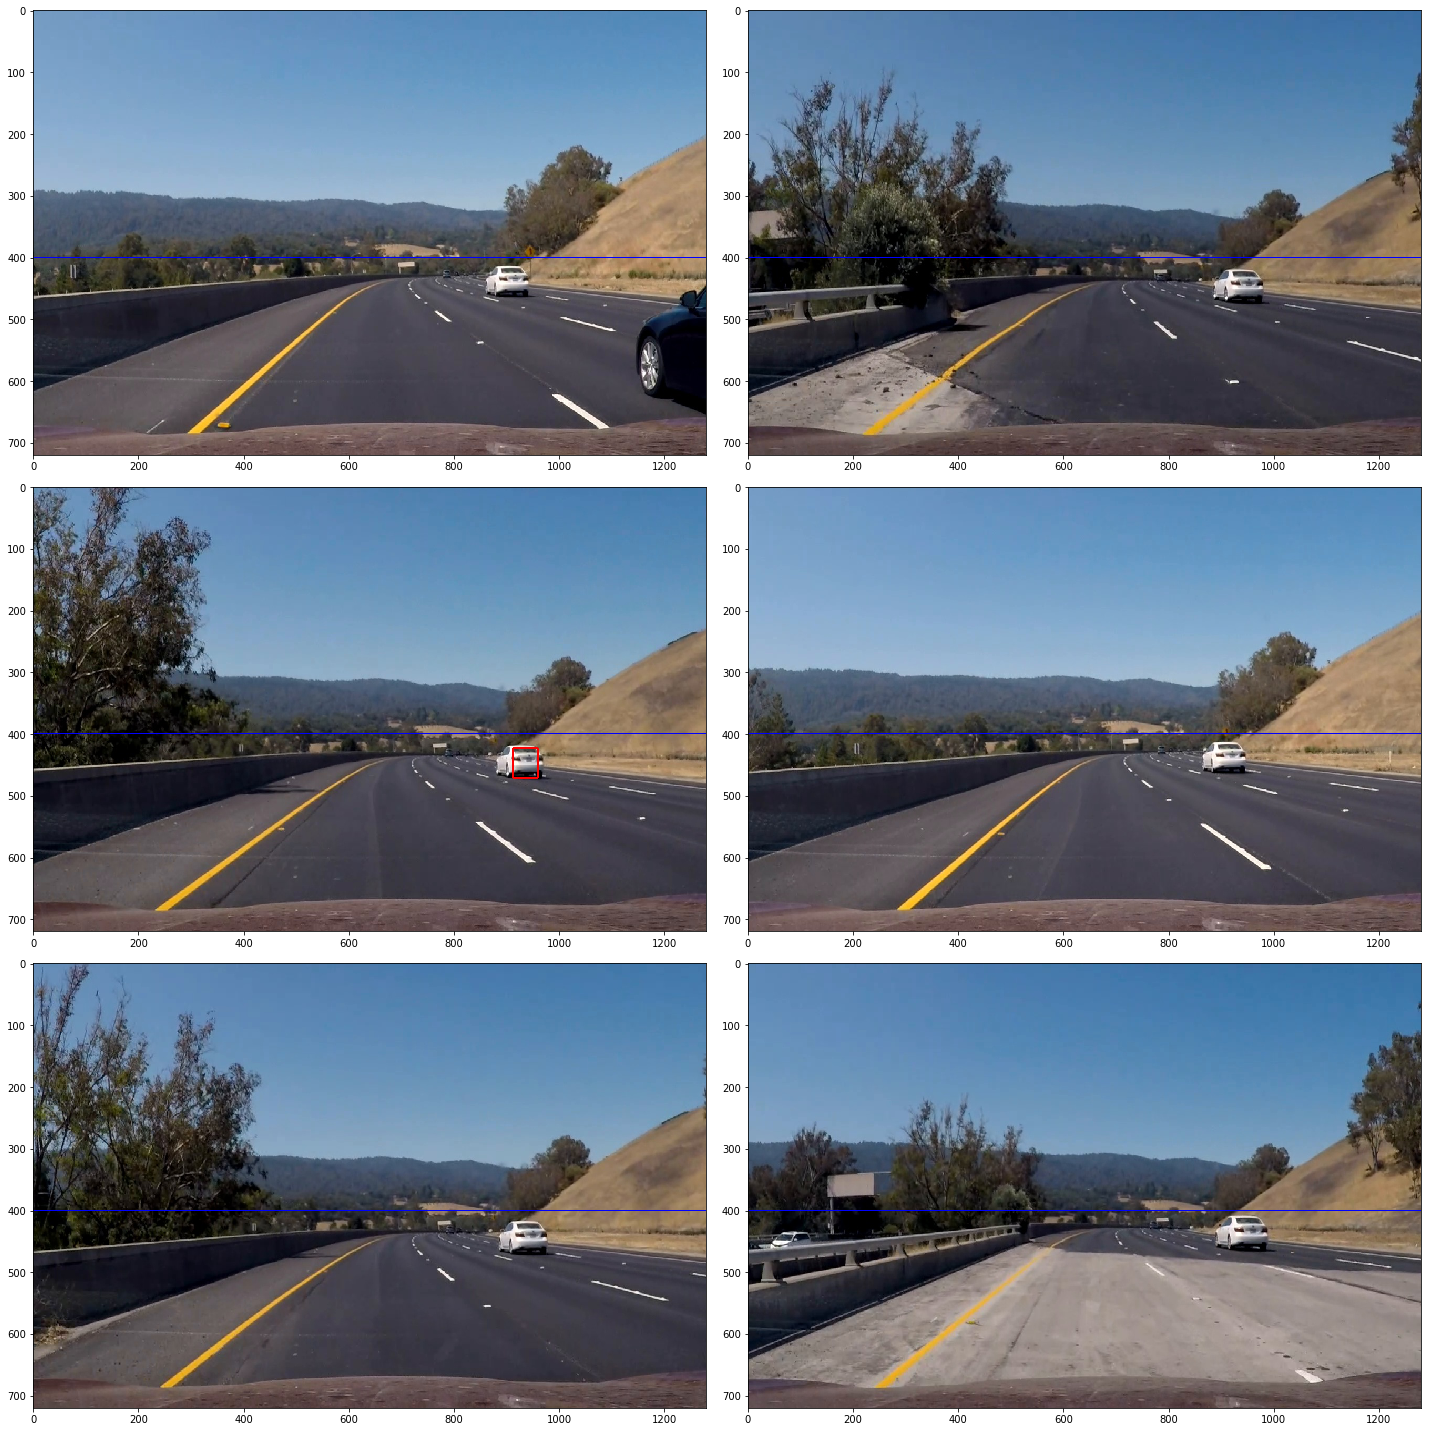

In [35]:
drawn_imgs = [find_cars(i, scales=[0.65, 0.75, 0.85]) for i in video_images]
show_n_m_grid(drawn_imgs, cmap=None, axis='on', rows=3, cols=2)